# Zadanie w pliku ./zadanie.txt

In [53]:
# Inizjalizacja

import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

class PCamDataset(Dataset):
    """
    Custom Dataset for loading the microscopic histopathology images within the PCam dataset
    """
    def __init__(self, csv_file, transform=None, num_samples=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations
            transform (callable, optional): Optional transform to be applied on a sample
            num_samples (int, optional): Number of samples to load. If None, loads all samples
        """
        self.annotations = pd.read_csv(csv_file)
        if num_samples is not None:
            self.annotations = self.annotations.head(num_samples)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.float)
        return image, label

In [54]:
# Ptrzetwarzanie wstępne 

train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [55]:
# Ładowanie zbioru treningowego
train_dataset = PCamDataset(csv_file='data/train_labels.csv', transform=train_transform)

# Dataloader zbioru treningowego
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [56]:
# Przetwarzanie wstępne dla danych testowych i walidacyjnych

val_test_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [57]:
# Ładowanie zbiorów walidacyjnych
val_dataset = PCamDataset(csv_file='data/validation_labels.csv', transform=val_test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = PCamDataset(csv_file='data/test_labels.csv', transform=val_test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
# Tworzenie CNN

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Obliczenia rozmiaru po warstwach konwolucyjnych i max pooling:
        # Obraz 96x96
        # po conv1 (96x96) -> po pool (48x48)
        # po conv2 (48x48) -> po pool (24x24)
        # po conv3 (24x24) -> po pool (12x12)
        # Liczba kanałów na wyjściu z conv3 to 128
        # więc rozmiar spłaszczonego tensora to 128 * 12 * 12 = 18432
        self.fc1 = nn.Linear(in_features=128 * 12 * 12, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Spłaszczenie
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)).squeeze(1) # squeeze(1) usuwa wymiar o rozmiarze 1

        return x

cnn_model = SimpleCNN()

In [59]:
# Wykorzystanie GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
cnn_model.to(device)

Using device: cuda


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [60]:
# Inicjalizacja optymalizatora

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)

Epoch 1/2500, Train Loss: 0.6271, Val Loss: 0.5879
Epoch 2/2500, Train Loss: 0.5859, Val Loss: 0.5270
Epoch 3/2500, Train Loss: 0.5379, Val Loss: 0.5684
Epoch 4/2500, Train Loss: 0.5442, Val Loss: 0.4985
Epoch 5/2500, Train Loss: 0.4931, Val Loss: 0.5131
Epoch 6/2500, Train Loss: 0.5110, Val Loss: 0.4984
Epoch 7/2500, Train Loss: 0.4746, Val Loss: 0.4975
Epoch 8/2500, Train Loss: 0.4616, Val Loss: 0.5482
Epoch 9/2500, Train Loss: 0.4813, Val Loss: 0.4682
Epoch 10/2500, Train Loss: 0.4742, Val Loss: 0.4840
Epoch 11/2500, Train Loss: 0.4601, Val Loss: 0.4712
Epoch 12/2500, Train Loss: 0.4530, Val Loss: 0.4686
Epoch 13/2500, Train Loss: 0.4446, Val Loss: 0.4742
Epoch 14/2500, Train Loss: 0.4360, Val Loss: 0.5245
Epoch 15/2500, Train Loss: 0.4277, Val Loss: 0.4754
Epoch 16/2500, Train Loss: 0.4314, Val Loss: 0.4965
Epoch 17/2500, Train Loss: 0.3953, Val Loss: 0.4665
Epoch 18/2500, Train Loss: 0.3933, Val Loss: 0.4489
Epoch 19/2500, Train Loss: 0.3747, Val Loss: 0.5141
Epoch 20/2500, Train 

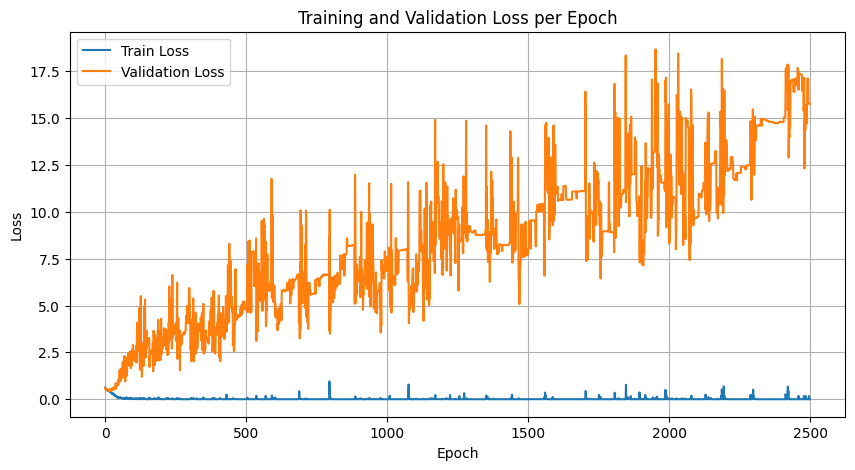

In [61]:
# Trening

num_epochs = 2500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    cnn_model.train()  # Ustawienie modelu w tryb treningowy
    total_train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    cnn_model.eval()  # Ustawienie modelu w tryb ewaluacji
    total_val_loss = 0.0
    with torch.no_grad(): # Wyłączenie obliczania gradientów
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Wizualizacja strat
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Generowanie predykcji zbioru testowego

test_pred_probs = []
test_pred_labels = []
true_labels = [] # Dodajemy do przechowywania prawdziwych etykiet do oceny

cnn_model.eval() # Ustawienie modelu w tryb ewaluacji
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        #labels są potrzebne do oceny, ale nie do predykcji
        
        outputs = cnn_model(images)
        test_pred_probs.extend(outputs.cpu().numpy())
        
        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)
true_labels = np.array(true_labels)

Accuracy: 0.8250
Precision: 0.8333
Recall: 0.8252
F1-Score: 0.8293
ROC AUC: 0.8522


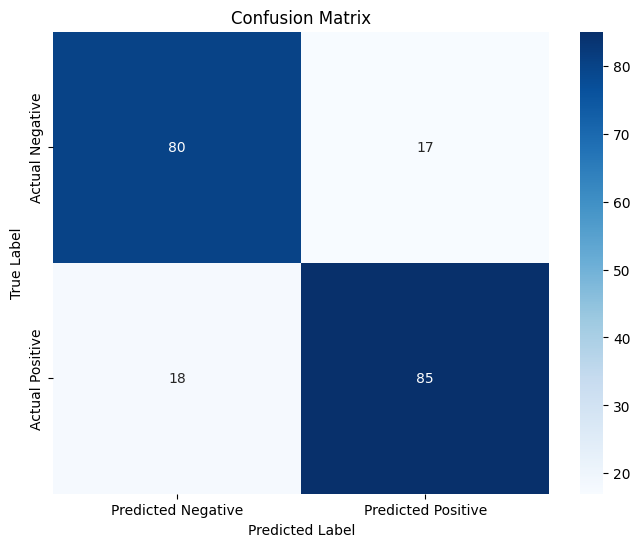

In [63]:
# Ocena

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Obliczanie metryk
accuracy = accuracy_score(true_labels, test_pred_labels)
precision = precision_score(true_labels, test_pred_labels)
recall = recall_score(true_labels, test_pred_labels)
f1 = f1_score(true_labels, test_pred_labels)
roc_auc = roc_auc_score(true_labels, test_pred_probs) # Dla ROC AUC potrzebujemy prawdopodobieństw

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Macierz konfuzji
cm = confusion_matrix(true_labels, test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()